In [70]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

data = pd.read_csv('C:/.../opm_raw.txt', low_memory=False)

def pre_process(df):
    
    data = df.iloc[:,2:]
    
    data['Year'] = data['EFDATET'].apply(lambda x: x[4:])
    data['Month'] = data['EFDATET'].apply(lambda x: x[:2])
    data['QTRT'] = data['QTRT'].apply(lambda x: x[:7])
    
    data_dummy = pd.get_dummies(data[['AGELVLT', 'AGYSUBT', 'AGYT', 'AGYTYPT', 'COUNT', 'FYT',
       'GSEGRD', 'LOCT', 'LOCTYPT', 'LOS', 'LOSLVLT', 'OCCFAMT', 'OCCT',
       'OCCTYPT', 'PATCOT', 'PAYPLANT', 'PPGRD', 'PPGROUPT', 'QTRT', 'SALARY',
       'SALLVLT', 'TOAT', 'TOATYPT', 'WORKSCHT', 'WSTYPT', 'ACCT.1',
       'Year', 'Month']])
    
    whole = pd.concat([data_dummy, data['EFDATET']], axis = 1)
    # 2017 data removed for testing data 
    test_data = whole[whole['Year_2017'] == 1]
    
    train_data = whole[whole['Year_2017'] != 1]
    
    test_data = test_data.drop(['Year_2017'], axis = 1)
    
    train_data = train_data.drop(['Year_2017'], axis = 1)
    
    return train_data, test_data


def normalize(df):
    
    df = df.groupby('EFDATET').sum()
    
    for col in list(df.columns):
       
        mean, std = df[col].mean(), df[col].std()

        df.loc[:, col] = (df[col] -mean) /(std + 1) 
        
    
        
    y = df['ACCT.1'].reset_index().iloc[:,1]
    
    y = y.values
    
    X = df.drop(['ACCT.1'], axis = 1).reset_index().iloc[:,1:]
    
    X = X.values
        
    return X, y, df  
    


In [71]:
train, test = pre_process(data)

In [72]:
X_train, y_train, df_train = normalize(train)

In [73]:
X_test, y_test, df_test = normalize(test)

In [74]:
import tensorflow
from tensorflow.keras.models import Sequential 
from tensorflow.keras.layers import Dense, Activation
from tensorflow.keras import losses
from tensorflow.keras import optimizers

In [75]:
# instantiate model 

epochs = 50
batch_size = 75
learning_rate = .005

model = Sequential()

# input/ hidden  

model.add(Dense(1400, input_shape=(train.shape[1]-2,)))
model.add(Activation('relu'))

# hidden layer

model.add(Dense(700))
model.add(Activation('relu'))

# hidden layer 

model.add(Dense(150))
model.add(Activation('relu'))

# output layer 

model.add(Dense(1))
print(model.summary())

sgd = optimizers.SGD(lr=learning_rate)
model.compile(loss=losses.mean_squared_error,
                  optimizer=sgd,
                  metrics=['mean_squared_error'])

fitted_model = model.fit(X_train, y_train, 
              batch_size=batch_size,
              validation_data=(X_test, y_test), 
              epochs=epochs,
              verbose=1)




_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_72 (Dense)             (None, 1400)              1976800   
_________________________________________________________________
activation_55 (Activation)   (None, 1400)              0         
_________________________________________________________________
dense_73 (Dense)             (None, 700)               980700    
_________________________________________________________________
activation_56 (Activation)   (None, 700)               0         
_________________________________________________________________
dense_74 (Dense)             (None, 150)               105150    
_________________________________________________________________
activation_57 (Activation)   (None, 150)               0         
_________________________________________________________________
dense_75 (Dense)             (None, 1)                 151       
Total para

Epoch 44/50
75/75 [==============================] - 0s 417us/step - loss: 5.9864e-04 - mean_squared_error: 5.9864e-04 - val_loss: 0.4551 - val_mean_squared_error: 0.4551
Epoch 45/50
75/75 [==============================] - 0s 417us/step - loss: 5.3334e-04 - mean_squared_error: 5.3334e-04 - val_loss: 0.4549 - val_mean_squared_error: 0.4549
Epoch 46/50
75/75 [==============================] - 0s 417us/step - loss: 4.7580e-04 - mean_squared_error: 4.7580e-04 - val_loss: 0.4548 - val_mean_squared_error: 0.4548
Epoch 47/50
75/75 [==============================] - 0s 417us/step - loss: 4.2491e-04 - mean_squared_error: 4.2491e-04 - val_loss: 0.4547 - val_mean_squared_error: 0.4547
Epoch 48/50
75/75 [==============================] - 0s 417us/step - loss: 3.7929e-04 - mean_squared_error: 3.7929e-04 - val_loss: 0.4546 - val_mean_squared_error: 0.4546
Epoch 49/50
75/75 [==============================] - 0s 417us/step - loss: 3.3915e-04 - mean_squared_error: 3.3915e-04 - val_loss: 0.4544 - val_m

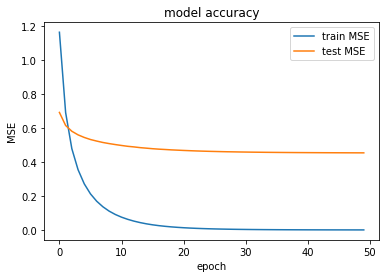

In [76]:
# plot of errors 
#print(fitted_model.history.keys())

plt.plot(fitted_model.history['mean_squared_error'])
plt.plot(fitted_model.history['val_mean_squared_error'])
plt.title('model accuracy')
plt.ylabel('MSE')
plt.xlabel('epoch')
plt.legend(['train MSE', 'test MSE'], loc='upper right')
plt.show()


In [77]:
def plot_predictions(df_preprocess, df_normal, features):
    
    df_original = df_preprocess.groupby('EFDATET').sum()
    
    mean = df_original.COUNT.mean()
    
    std = df_original.COUNT.std()
    
    actuals = df_normal.COUNT * (std + 1) + mean
    
    predictions = model.predict(features)
    
    unnormalized_predictions = (predictions * (std + 1) + mean).round()
    
    actuals = actuals.reset_index()
    
    table = pd.concat([actuals, pd.DataFrame(unnormalized_predictions, columns = ['PREDICTIONS'])], axis = 1)
    
    return table 

In [78]:
train_table = plot_predictions(train, df_train, X_train)

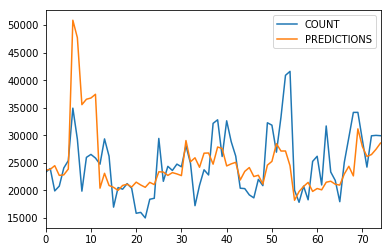

In [79]:
#Comparison to training data should cause overfitting

train_table[['EFDATET', 'COUNT', 'PREDICTIONS']].plot()

In [80]:
test_table = plot_predictions(test, df_test, X_test)
test_table['MONTH'] = pd.DatetimeIndex(test_table['EFDATET']).month
test_table.sort_values(by = ['MONTH'], inplace = True)
test_table


,EFDATET,COUNT,PREDICTIONS,MONTH
3,JAN 2017,32650.0,24150.0,1
2,FEB 2017,16142.0,17268.0,2
6,MAR 2017,13653.0,18033.0,3
0,APR 2017,23253.0,23303.0,4
7,MAY 2017,27434.0,25219.0,5
5,JUN 2017,22709.0,23453.0,6
4,JUL 2017,18962.0,21815.0,7
1,AUG 2017,22670.0,27002.0,8
8,SEP 2017,30618.0,25095.0,9


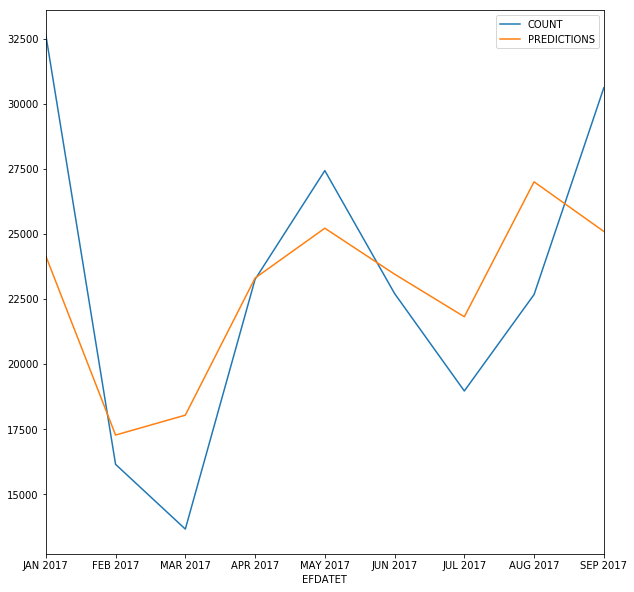

In [81]:
ax = plt.gca()
test_table.plot(x = 'EFDATET', y= 'COUNT', figsize=(10,10), ax = ax)
test_table.plot(x = 'EFDATET', y= 'PREDICTIONS', ax = ax)